In [ ]:
# config.py
from config import (
    ROSTER_SIZE,
    LEAGUE_SIZE,
    BONUS_PLAYER_POOL_MULT,
    G_SPLIT,
    W_SPLIT,
    B_SPLIT,
    SELECTED_COLUMNS,
    BREF_COLS,
    CORE_STATS,
    COLOR_PALETTE,
    FANTASYPROS_URL,
    NAME_OVERRIDES,
)

# data_io.py
from data_io import (
    load_or_generate_data,
)

# data_cleaning.py
from data_cleaning import (
    clean_name,
    clean_and_refine_nba_data,
)

# feature_engineering.py
from feature_engineering import (
    parse_awards_cell,
    calculate_fantasy_points,
    create_metrics,
)

# modeling.py
from modeling import (
    split_data_nba,
    create_baseline_nba,
    attach_model_results,
    tune_xgb_nba,
    create_model_nba,
    build_prediction_frame,
)

# data_viz.py
from data_viz import (
    plot_feature_importance,
    plot_actual_vs_pred,
    plot_resid_vs_pred,
    plot_resid_hist,
    plot_recent_seasons,
    plot_decile_calib,
)

# Standard libraries and external dependencies
import pandas as pd
import numpy as np
import unicodedata
import os
import re
from hyperopt import hp
import requests
from bs4 import BeautifulSoup

In [115]:
# Setting input variables
START_YEAR = 2000
END_YEAR = 2024
PRED_YEAR = END_YEAR + 1

# Defining player pool sizes for each position group
player_pool = (ROSTER_SIZE * LEAGUE_SIZE) * BONUS_PLAYER_POOL_MULT
g_pool = round(player_pool * G_SPLIT, 0)
w_pool = round(player_pool * W_SPLIT, 0)
b_pool = round(player_pool * B_SPLIT, 0)

In [30]:
# Create a data folder if not exists
if not os.path.exists('data'):
    os.makedirs('data')

In [31]:
api_df, bref_df = load_or_generate_data(START_YEAR, END_YEAR)

Loaded existing API data from CSV file.
Loaded existing BRef data from CSV file.


In [32]:
api_df = clean_and_refine_nba_data(api_df)
bref_df = clean_and_refine_nba_data(bref_df)

# Keep only selected columns for the model
api_df = api_df[SELECTED_COLUMNS]
bref_df = bref_df[BREF_COLS]

In [33]:
display(api_df)

,player_id,player_name_clean,season,year,age,pts,reb,ast,gp,usg_pct,...,playoff_nba_fantasy_pts,playoff_plus_minus,playoff_efg_pct,playoff_off_rating,playoff_net_rating,playoff_ast_to,playoff_efg_pct,playoff_pie,playoff_fgm_pg,playoff_fga_pg
0,920,ac green,2000-01,2001,37.0,367,313,39,82,0.137,...,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.0
1,2062,aj guyton,2000-01,2001,23.0,198,36,64,33,0.167,...,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.0
2,243,aaron mckie,2000-01,2001,28.0,878,311,377,76,0.186,...,725.3,-14.0,0.511,102.7,7.3,1.86,0.511,0.119,4.4,9.4
3,228,adam keefe,2000-01,2001,31.0,168,209,36,67,0.114,...,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.0
4,1502,adonal foyle,2000-01,2001,26.0,342,405,48,58,0.138,...,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9087,1641744,zach edey,2024-25,2025,23.0,610,548,65,66,0.156,...,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.0
9088,203897,zach lavine,2024-25,2025,30.0,1724,315,310,74,0.251,...,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.0
9089,1630192,zeke nnaji,2024-25,2025,24.0,184,90,23,57,0.119,...,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.0
9090,1630533,ziaire williams,2024-25,2025,23.0,632,287,84,63,0.179,...,0.0,0.0,0.000,0.0,0.0,0.00,0.000,0.000,0.0,0.0


In [34]:
display(bref_df)

,player_name_clean,year,age,team,pos,mp,min_pg,trb_pg,ast_pg,stl_pg,...,rookie_year,was_drafted,pk,college,all_star,all_def,dpoy,mvp,all_nba,roy
0,aaron brooks,2008,23.0,HOU,PG,608.0,11.921569,4.9,7.6,1.1,...,2008.0,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
1,aaron brooks,2009,24.0,HOU,PG,1998.0,24.975000,4.2,6.3,1.2,...,2008.0,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
2,aaron brooks,2010,25.0,HOU,PG,2919.0,35.597561,3.8,7.6,1.2,...,2008.0,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
3,aaron brooks,2011,26.0,2TM,PG,1284.0,21.762712,3.1,9.2,1.3,...,2008.0,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
4,aaron brooks,2013,28.0,2TM,PG,997.0,18.811321,4.1,5.9,1.5,...,2008.0,1,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12244,zydrunas ilgauskas,2010,34.0,CLE,C,1339.0,20.921875,13.5,1.9,0.5,...,1997.0,1,20.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
12245,zydrunas ilgauskas,2011,35.0,MIA,C,1145.0,15.902778,13.2,1.2,1.1,...,1997.0,1,20.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
12246,zylan cheatham,2020,24.0,NOP,PF,51.0,12.750000,8.2,2.7,0.9,...,2020.0,0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
12247,zylan cheatham,2022,26.0,UTA,SF,5.0,5.000000,0.0,0.0,0.0,...,2020.0,0,0.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# Merging dataframes together
## Protip, "ws" values will be null for players that did not match correctly on name and year
combined_df = pd.merge(
    api_df,
    bref_df,
    on=["player_name_clean", "year"],
    how="left",
    suffixes=("", "_bref"),
)

# If duplicate columns appear in the dataset, keep only the first occurrence
combined_df = combined_df.loc[:, ~combined_df.columns.duplicated()]

# Drop rows where a player's team information is missing
combined_df = combined_df[combined_df["team"].notna()]

# Sort the dataframe by player name clean & year
combined_df = combined_df.sort_values(by=["player_name_clean", "year"]).reset_index(drop=True)

# Insert the team & ws columns to be placed after the year column for reference
combined_df.insert(
    combined_df.columns.get_loc("year") + 1,
    "team",
    combined_df.pop("team"),
)
combined_df.insert(
    combined_df.columns.get_loc("year") + 2,
    "ws",
    combined_df.pop("ws"),
)

In [36]:
display(combined_df)

,player_id,player_name_clean,season,year,team,ws,age,pts,reb,ast,...,rookie_year,was_drafted,pk,college,all_star,all_def,dpoy,mvp,all_nba,roy
0,201166,aaron brooks,2007-08,2008,HOU,1.4,23.0,264,56,87,...,2008.0,1.0,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
1,201166,aaron brooks,2008-09,2009,HOU,3.6,24.0,894,157,238,...,2008.0,1.0,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
2,201166,aaron brooks,2009-10,2010,HOU,5.5,25.0,1604,215,434,...,2008.0,1.0,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
3,201166,aaron brooks,2010-11,2011,2TM,1.1,26.0,634,78,233,...,2008.0,1.0,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
4,201166,aaron brooks,2012-13,2013,2TM,0.8,28.0,376,80,114,...,2008.0,1.0,26.0,Oregon,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9033,980,zydrunas ilgauskas,2006-07,2007,CLE,6.6,32.0,925,599,123,...,1997.0,1.0,20.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
9034,980,zydrunas ilgauskas,2007-08,2008,CLE,6.1,33.0,1029,682,104,...,1997.0,1.0,20.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
9035,980,zydrunas ilgauskas,2008-09,2009,CLE,5.6,34.0,838,490,64,...,1997.0,1.0,20.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0
9036,980,zydrunas ilgauskas,2009-10,2010,CLE,2.5,35.0,474,345,48,...,1997.0,1.0,20.0,NO COLLEGE,0.0,0.0,0.0,0.0,0.0,0.0


In [37]:
combined_df = calculate_fantasy_points(combined_df)

In [38]:
awards_parsed = combined_df["awards"].apply(parse_awards_cell)

awards_df = pd.DataFrame(list(awards_parsed), index=combined_df.index)

combined_df = pd.concat([combined_df, awards_df], axis=1)

# Dropping the original Awards column
combined_df = combined_df.drop(columns=["awards"])

In [39]:
# Adding additional aggregated metrics for core statistics
combined_df = create_metrics(combined_df, CORE_STATS)

# Creating age based features
combined_df["years_in_league"] = combined_df["year"] - combined_df["rookie_year"]
combined_df["age_bucket"] = pd.cut(
    combined_df["age"],
    bins=[18, 22, 26, 30, 34, 45],
    labels=["rookie", "young", "prime", "veteran", "late"],
)

# Creating feature to identify COVID-impacted season
combined_df["covid_flag"] = np.where(combined_df["year"] == 2020, 1, 0)
# Creating feature to identify post-COVID season (2021) due to limited games in 2020
combined_df["post_covid_flag"] = np.where(combined_df["year"] == 2021, 1, 0)

# Add incomplete_career_history flag to identify players that are missing a full capture of playing history
combined_df["incomplete_career_history"] = (
    (combined_df["rookie_year"] < (START_YEAR))
    | (
        (combined_df["college"] == "NO COLLEGE")
        & (combined_df["age"] >= 25)
        & (combined_df["year"] == (START_YEAR + 1))
    )
).astype(int)
# Setting each player's incomplete_career_history flag to 1 if any season is marked as incomplete
combined_df["incomplete_career_history"] = (
    combined_df.groupby("player_name_clean")["incomplete_career_history"].transform("max")
)

# Creating feature to identify career eligble games played
combined_df["eligible_games_played"] = combined_df["career_gp"] / (82 * (combined_df["years_in_league"] + 1))
# Adding 3 year average of eligible games played to emphasize recent availability
combined_df["avg3yr_eligible_games_played"] = combined_df.groupby("player_name_clean")["eligible_games_played"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Creating a feature to indicate whether a player was significantly injured during a season
combined_df["injury_flag"] = np.where(
    (combined_df["gp"] < 60) & (combined_df["min_pg"] >= 15), 1, 0
)
# Adding a 3 year average of injury flag to indicate frequency of injuries
combined_df["avg3yr_injury_flag"] = combined_df.groupby("player_name_clean")["injury_flag"].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)
# Adding cumulative sum career total of injury seasons
combined_df["career_injury_seasons"] = combined_df.groupby("player_name_clean")["injury_flag"].cumsum()


In [40]:
# Fixing up columns that need to be reformatted for modeling
# Converting college column to categorical variable
combined_df["college"] = combined_df["college"].astype("category")
combined_df["pos"] = combined_df["pos"].astype("category")
combined_df["team"] = combined_df["team"].astype("category")

In [41]:
# Displaying combined_df sorted by player name & year
combined_df = combined_df.sort_values(by=["player_name_clean", "year"]).reset_index(drop=True)
display(combined_df)

,player_id,player_name_clean,season,year,team,ws,age,pts,reb,ast,...,years_in_league,age_bucket,covid_flag,post_covid_flag,incomplete_career_history,eligible_games_played,avg3yr_eligible_games_played,injury_flag,avg3yr_injury_flag,career_injury_seasons
0,201166,aaron brooks,2007-08,2008,HOU,1.4,23.0,264,56,87,...,0.0,young,0,0,0,0.621951,0.621951,0,0.000000,0
1,201166,aaron brooks,2008-09,2009,HOU,3.6,24.0,894,157,238,...,1.0,young,0,0,0,0.798780,0.710366,0,0.000000,0
2,201166,aaron brooks,2009-10,2010,HOU,5.5,25.0,1604,215,434,...,2.0,young,0,0,0,0.865854,0.762195,0,0.000000,0
3,201166,aaron brooks,2010-11,2011,2TM,1.1,26.0,634,78,233,...,3.0,young,0,0,0,0.829268,0.831301,1,0.333333,1
4,201166,aaron brooks,2012-13,2013,2TM,0.8,28.0,376,80,114,...,5.0,prime,0,0,0,0.660569,0.785230,1,0.666667,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9033,980,zydrunas ilgauskas,2006-07,2007,CLE,6.6,32.0,925,599,123,...,10.0,veteran,0,0,1,0.534368,0.489595,0,0.000000,1
9034,980,zydrunas ilgauskas,2007-08,2008,CLE,6.1,33.0,1029,682,104,...,11.0,veteran,0,0,1,0.564024,0.530358,0,0.000000,1
9035,980,zydrunas ilgauskas,2008-09,2009,CLE,5.6,34.0,838,490,64,...,12.0,veteran,0,0,1,0.581614,0.560002,0,0.000000,1
9036,980,zydrunas ilgauskas,2009-10,2010,CLE,2.5,35.0,474,345,48,...,13.0,late,0,0,1,0.595819,0.580486,0,0.000000,1


# Modeling

## Defining training & testing datasets

In [42]:
# Splitting the data into training, testing, and validation sets
X_train, X_val, X_test, y_train, y_val, y_test, feature_cols = split_data_nba(combined_df, PRED_YEAR)

# Scaling is not explicitly required for tree-based models, but keeping the process for potential future use
# X_train, X_test, scaler = scale_numeric_train_test(X_train, X_test)

## Creating Baseline Model

In [43]:
# Generating baseline model and predictions to measure final model performance
baseline_model, baseline_pred = create_baseline_nba(X_train, X_test, y_train, y_test)

[Baseline] RMSE: 532.797
[Baseline] MAE:  424.778
[Baseline] R^2:  0.571


In [44]:
# Attach baseline model results to testing set for review
results = attach_model_results(X_test, baseline_pred, combined_df)

display(results)

,player_name_clean,season,year,fantasy_points,fantasy_points_future,predicted_fantasy_points,prediction_diff
6626,nikola jokic,2021-22,2022,4337.8,3842.4,4296.947754,454.55
5495,lebron james,2006-07,2007,3758.2,4170.9,3779.341309,-391.56
5018,kevin garnett,2001-02,2002,3961.2,4444.9,3738.655518,-706.24
8216,tim duncan,2003-04,2004,3446.3,3018.9,3578.332031,559.43
2613,dwyane wade,2005-06,2006,3654.5,2550.8,3569.920654,1019.12
...,...,...,...,...,...,...,...
6952,pj tucker,2022-23,2023,828.0,239.0,428.477722,189.48
7436,royal ivey,2006-07,2007,338.7,880.6,396.839417,-483.76
8833,wenyen gabriel,2021-22,2022,310.4,906.2,387.270996,-518.93
4620,josh okogie,2021-22,2022,345.5,1194.7,375.924377,-818.78


## Creating Final Model

In [66]:
# Building a prediction dataframe and feature predictions dataframe
pred_df, X_pred = build_prediction_frame(
    combined_df,
    pred_year=PRED_YEAR,
    feature_cols=feature_cols,
)

In [46]:
# Define Hyperopt search space for final model tuning
MAX_DEPTH_CHOICES = [3, 4, 5, 6]
space = {
    "learning_rate": hp.loguniform("learning_rate", np.log(0.15), np.log(0.2)),
    "max_depth": hp.choice("max_depth", MAX_DEPTH_CHOICES),
    "subsample": hp.uniform("subsample", 0.7, 1.0),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.7, 0.9),
    "colsample_bynode": hp.uniform("colsample_bynode", 0.5, 1.0),

    "min_child_weight": hp.loguniform("min_child_weight", np.log(1.0), np.log(15.0)),
    "reg_lambda": hp.loguniform("reg_lambda", np.log(0.5), np.log(12.0)),
    "reg_alpha": hp.loguniform("reg_alpha", np.log(1e-4), np.log(4.0)),
    "gamma": hp.loguniform("gamma", np.log(1e-4), np.log(4.0)),
}

# Tune Model
best_params = tune_xgb_nba(
    X_train,
    X_val,
    y_train,
    y_val,
    space=space,
    metric="rmse",
    evals=10,
    max_depth_choices=MAX_DEPTH_CHOICES,
)

final_model, final_pred = create_model_nba(
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
    final_params=best_params,
)

100%|██████████| 10/10 [00:04<00:00,  2.20trial/s, best loss: 524.7369116642409]
Best Parameters: {'learning_rate': 0.17494795734351287, 'max_depth': 3, 'subsample': 0.9569502883857658, 'colsample_bytree': 0.795653107292145, 'colsample_bynode': 0.5029664568156816, 'min_child_weight': 3.604389853190562, 'reg_lambda': 4.79990117978927, 'reg_alpha': 1.1040076405245125, 'gamma': 0.0032737612084449102}
Best iteration: 64
[Final tuned] RMSE: 525.322
[Final tuned] MAE:  414.490
[Final tuned] R^2:  0.598


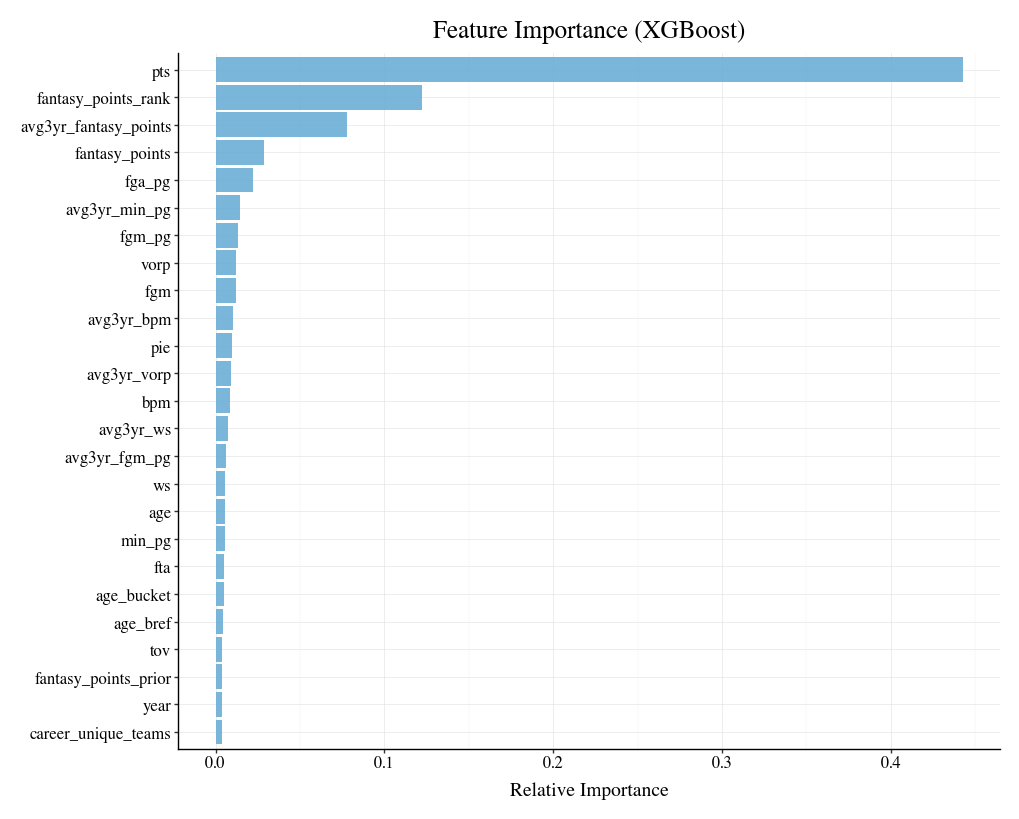

In [47]:
# Plotting out the feature importance of the final model
fi_plot = plot_feature_importance(
    final_model,
    X_train=X_train,  # your training feature frame
    top_n=25,
    importance_type="gain",
)

display(fi_plot)

In [48]:
# Attach final model results to validation set for review
results = attach_model_results(X_val, final_pred, combined_df)

display(results)

,player_name_clean,season,year,fantasy_points,fantasy_points_future,predicted_fantasy_points,prediction_diff
3712,james harden,2016-17,2017,4520.3,3815.8,3931.284424,115.48
8215,tim duncan,2002-03,2003,4237.6,3446.3,3872.309570,426.01
5625,luka doncic,2023-24,2024,4304.4,2624.3,3800.399658,1176.10
5006,kevin durant,2013-14,2014,4179.1,1137.6,3789.982666,2652.38
3710,james harden,2014-15,2015,3936.3,4091.2,3726.547852,-364.65
...,...,...,...,...,...,...,...
459,anfernee hardaway,2004-05,2005,529.8,201.5,441.289520,239.79
46,aaron williams,2004-05,2005,179.0,233.5,404.721710,171.22
8316,tom gugliotta,2002-03,2003,321.5,569.9,370.121948,-199.78
3874,jason collins,2010-11,2011,279.4,122.6,289.133331,166.53


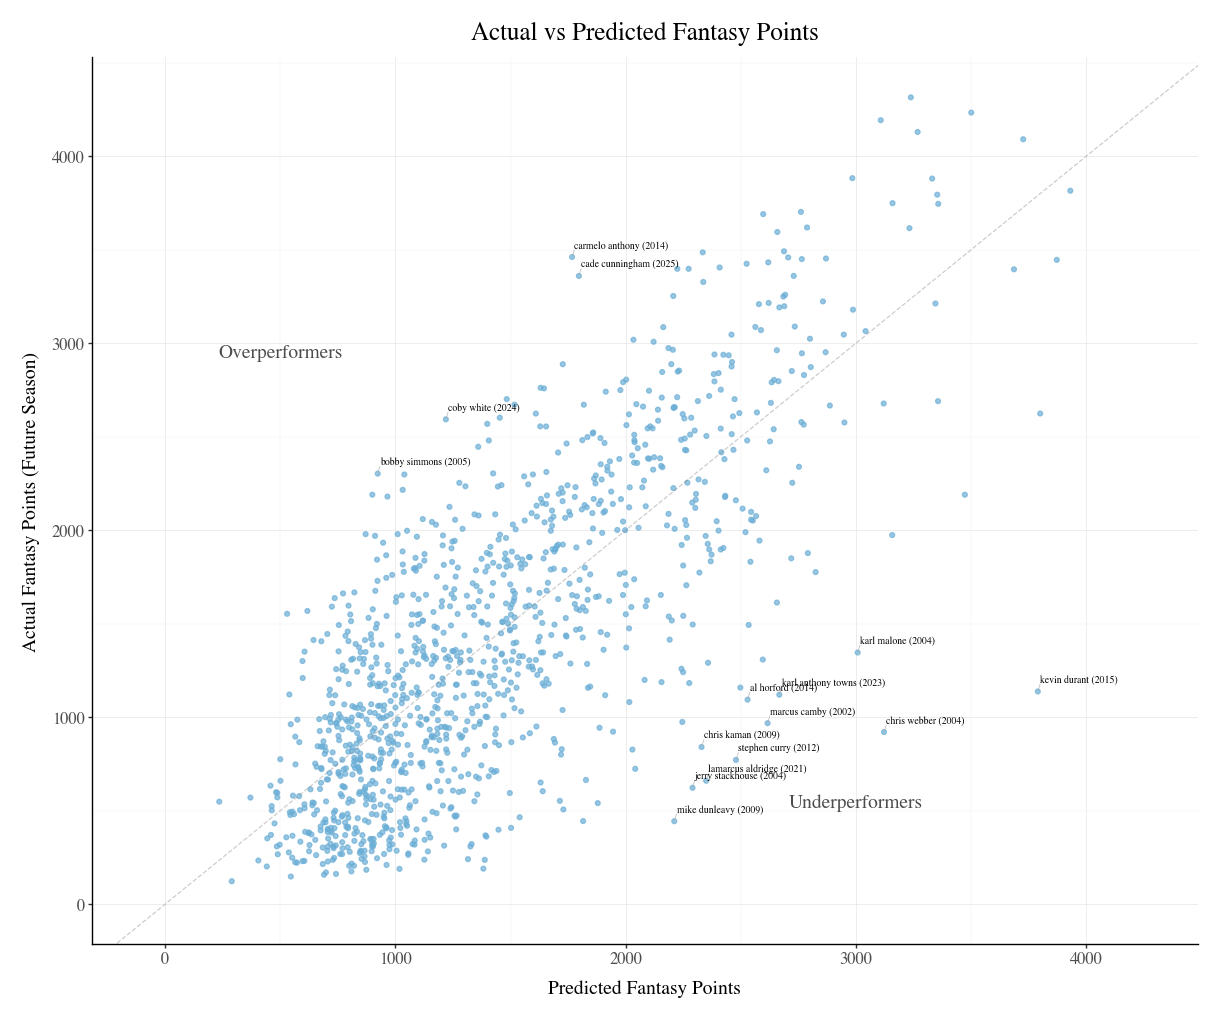

In [49]:
## Plot for Actual vs Predicted Fantasy Points
p = plot_actual_vs_pred(results, COLOR_PALETTE, top_n=15)
display(p)

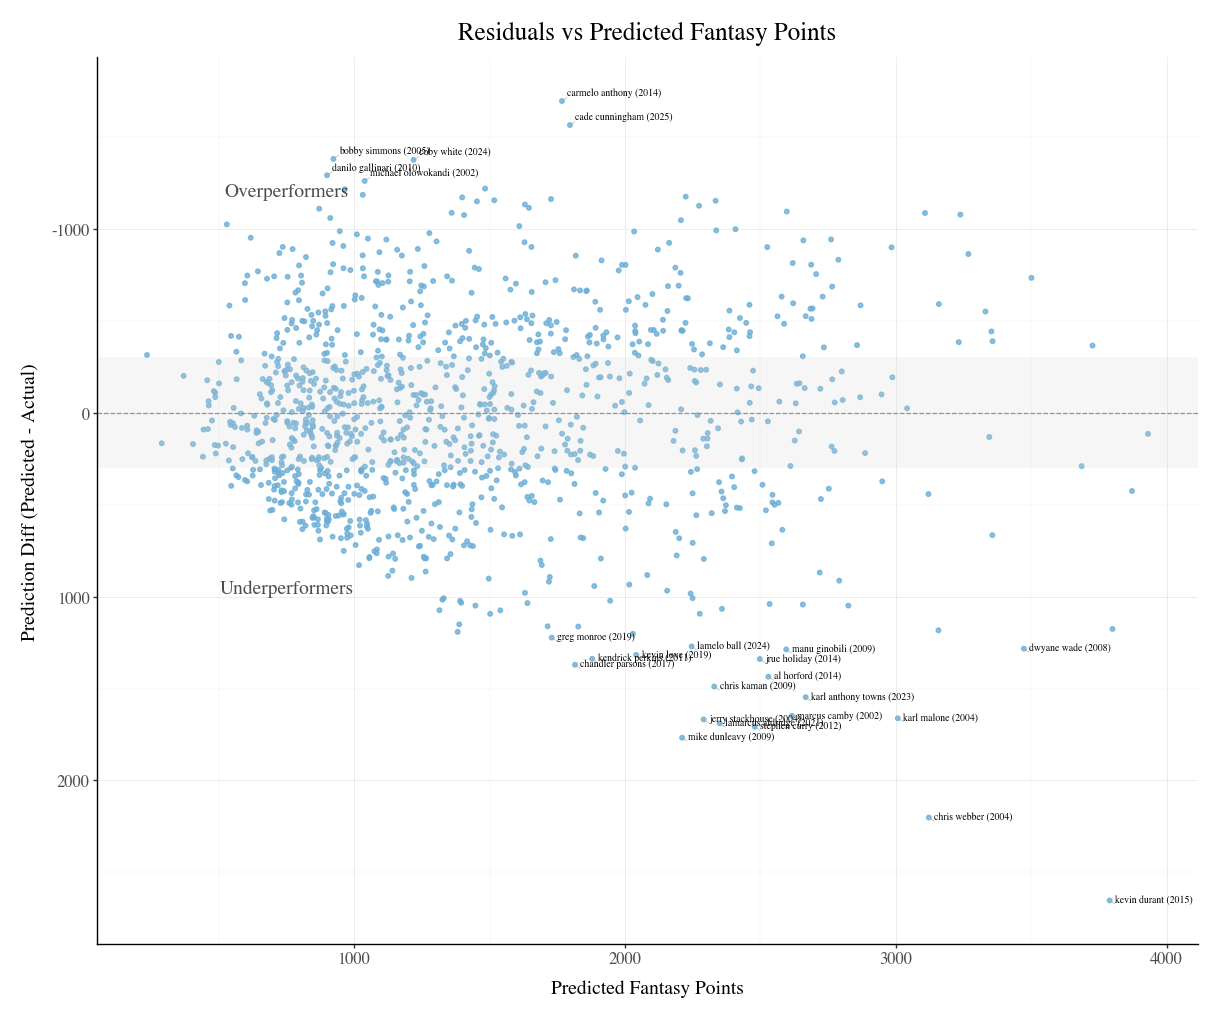

In [50]:
## Plot for Residuals vs Predicted Fantasy Points
p = plot_resid_vs_pred(results, COLOR_PALETTE, top_n=25)
display(p)

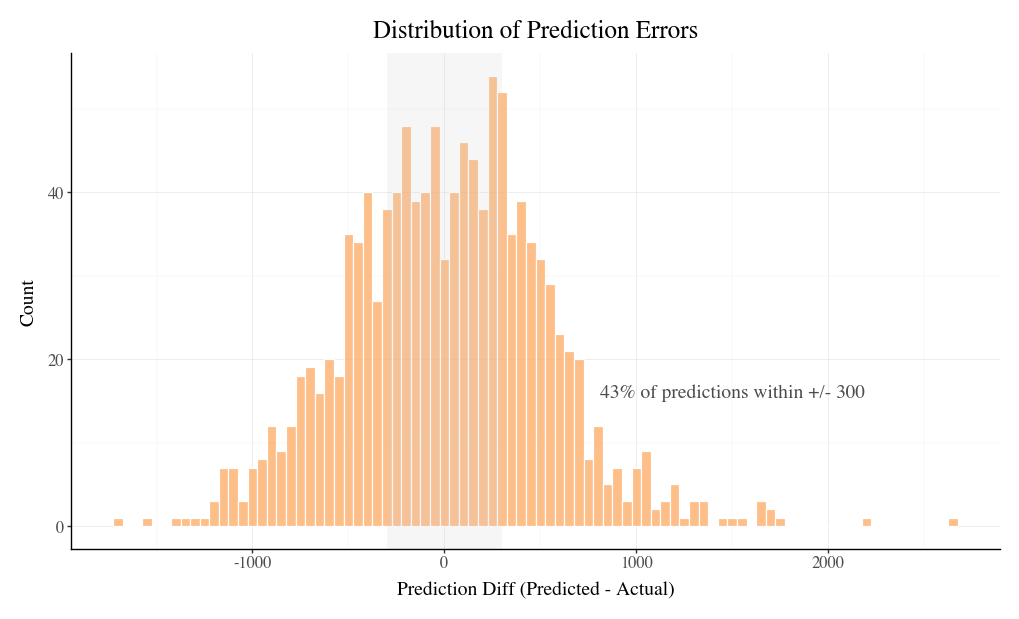

In [51]:
## Plot for Residuals Histogram
p = plot_resid_hist(results, COLOR_PALETTE, band=300)
display(p)

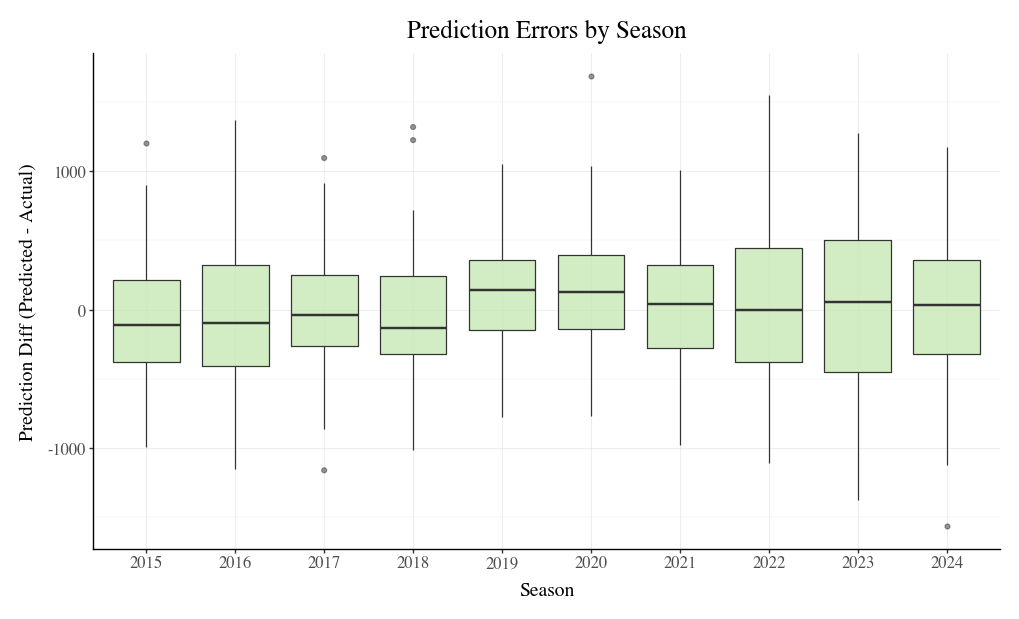

In [52]:
# Plotting prediction performance for the last 10 seasons
p = plot_recent_seasons(results, COLOR_PALETTE, n_seasons=10)
display(p)

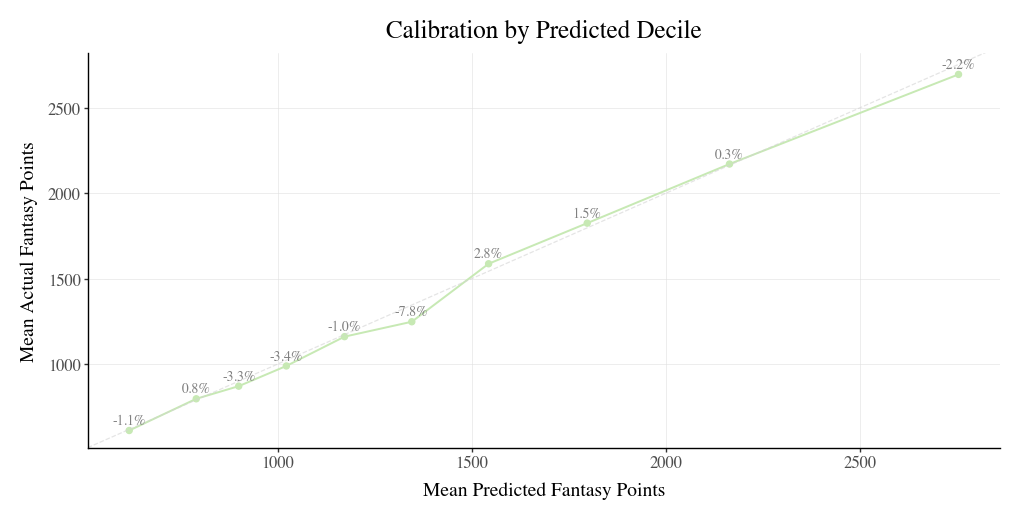

In [53]:
# Plotting performance by prediction decile
p = plot_decile_calib(results, COLOR_PALETTE)
display(p)

In [67]:
# Making final predictions & adding them back onto the prediction dataframe
pred_values = final_model.predict(X_pred)

pred_df["predicted_fantasy_points"] = pred_values
pred_df["predicted_rank"] = pred_df["predicted_fantasy_points"].rank(method="min", ascending=False).astype(int)


pred_eval_df = (pred_df[["player_name_clean", "fantasy_points", "predicted_fantasy_points", "fantasy_points_rank", "predicted_rank"]].sort_values(
        by="predicted_rank", ascending=True)
)

pred_eval_df['predicted_diff'] = (pred_eval_df['fantasy_points_rank'] - pred_eval_df['predicted_rank']).astype(int)

pred_eval_df = pred_eval_df[pred_eval_df['predicted_rank'] <= 250].reset_index(drop=True)

display(pred_eval_df)

,player_name_clean,fantasy_points,predicted_fantasy_points,fantasy_points_rank,predicted_rank,predicted_diff
0,shai gilgeous alexander,4108.8,3461.193848,2.0,1,1
1,nikola jokic,4501.4,3411.326904,1.0,2,-1
2,giannis antetokounmpo,3845.1,3400.826172,3.0,3,0
3,domantas sabonis,3157.9,3313.305908,13.0,4,9
4,lebron james,3294.7,3142.316650,10.0,5,5
...,...,...,...,...,...,...
245,grayson allen,1262.3,1038.480225,198.0,246,-48
246,quinten post,670.6,1035.659546,312.0,247,65
247,robert williams,410.1,1033.097290,379.0,248,131
248,isaac okoro,716.0,1025.742676,306.0,249,57


In [ ]:
# Write out final prediction evaluations to CSV
# pred_eval_df.to_csv("nba_fantasy_predictions.csv", index=False)

In [ ]:
## TODO: Revise the process to scrape fantasy pros as needed based on changes to their site structure
## TODO: Create player relative value metrics based on relative positional performance

In [100]:
# Creating function to assign position groups to players

def assign_position_group(df: pd.DataFrame):
    """
    Assigns a positional group based on the player's position.

    Parameters:
    df (pd.DataFrame): The DataFrame containing player data.
    position_col (str): The column name indicating the player's position.

    Returns:
    pd.DataFrame: The DataFrame with an additional 'position_group' column.
    """
    # Define position group mappings, Designated Hitters will default as infielders

    position_mapping = {
        "G": {"PG", "SG"},
        "W": {"SF", "PF"},
        "B": {"C"},
    }

    def map_position(pos):
        for group, positions in position_mapping.items():
            if pos in positions:
                return group
        return np.nan  # Unexpected values are set to NaN

    # Apply mapping function
    df["position_group"] = df['pos'].apply(map_position)

    return df

In [68]:
# List of player names that should keep their suffixes for fantasypros join (fantasypros includes suffixes for some players seemingly at random)
HOLDOUT_SUFFIX_NAMES = {
    "daron holmes ii",
    "dereck lively ii",
    "gary payton ii",
    "ronald holland ii"
}

def remove_suffixes(name):
    name_clean = name.strip().lower()
    if name_clean in HOLDOUT_SUFFIX_NAMES:
        return name  # Return original name if in holdout group
    # Remove common suffixes at the end of the name
    return re.sub(r'\s+(jr|sr|ii|iii|iv)$', '', name, flags=re.IGNORECASE).strip()

In [101]:
def scrape_fp_projections(url: str = FANTASYPROS_URL) -> pd.DataFrame:
    """
    Scrape the FantasyPros NBA overall rankings table and return as a DataFrame.
    Uses requests + BeautifulSoup to find the table with id="data".
    """
    # Fetch the page with a browser-like User-Agent
    headers = {"User-Agent": "Mozilla/5.0"}
    response = requests.get(url, headers=headers)
    response.raise_for_status()

    soup = BeautifulSoup(response.text, "html.parser")

    # Find the main data table (FantasyPros consistently uses id="data" on these pages)
    table = soup.find("table", {"id": "data"})
    if table is None:
        raise ValueError("Could not find table with id='data' on FantasyPros page.")

    # Extract header cells
    thead = table.find("thead")
    header_cells = thead.find_all("th")
    headers = [th.get_text(strip=True) for th in header_cells]

    # Extract body rows
    tbody = table.find("tbody")
    rows = []
    for tr in tbody.find_all("tr"):
        cells = [td.get_text(strip=True) for td in tr.find_all("td")]
        # Some rows may be empty / separators
        if cells:
            rows.append(cells)

    # Build DataFrame
    df = pd.DataFrame(rows, columns=headers)

    return df

In [102]:
def clean_name_fp(name: str) -> str:
    """
    Convert a FantasyPros player string into a normalized 'player_name_clean'-style string.
    Example: 'Nikola Jokic (DEN - C)' -> 'nikola jokic'
    """
    if not isinstance(name, str):
        return ""

    # Remove accents (é -> e, etc.)
    name = unicodedata.normalize("NFKD", name).encode("ascii", "ignore").decode("ascii")

    # Remove everything after the last closing parenthesis
    last_paren = name.rfind(")")
    if last_paren != -1:
        name = name[: last_paren + 1]

    # Drop anything in parentheses, e.g., " (DEN - C)"
    name = re.sub(r"\s*\(.*?\)", "", name)

    # Collapse whitespace & lowercase
    name = re.sub(r"\s+", " ", name).strip().lower()

    # Apply prior clean_name process to name
    name = clean_name(name)

    return name

In [103]:
# Function to extract first position from FantasyPros player string
def _extract_first_position(player_str):
    m = re.search(r'\(([^)]+)\)', str(player_str))
    if m:
        parts = m.group(1).split('-')
        if len(parts) > 1:
            positions = parts[1].split(',')
            return positions[0].strip()
    return None

def prepare_fantasypros_df() -> pd.DataFrame:
    """
    Scrape FantasyPros overall rankings and produce a cleaned dataframe
    with a `player_name_clean` column ready to join.
    """
    fp_raw = scrape_fp_projections(FANTASYPROS_URL)

    # Normalize column names to snake_case
    fp = fp_raw.copy()
    fp.columns = (
        fp.columns.astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace("%", "pct")
    )

    # FantasyPros normally has a 'player' column
    if "player" not in fp.columns:
        raise ValueError(
            f"'player' column not found in FantasyPros DF. Columns: {fp.columns.tolist()}"
        )

    # Create player_name_clean
    fp["player_name_clean"] = fp["player"].apply(clean_name_fp)

    # Extract first position from the player string
    fp["position"] = fp["player"].apply(_extract_first_position)

    # Apply your existing name overrides if you want alignment with other sources
    # (assumes NAME_OVERRIDES dict is already defined in your notebook)
    if "NAME_OVERRIDES" in globals():
        fp["player_name_clean"] = fp["player_name_clean"].replace(NAME_OVERRIDES)

    # Try to identify a rank column and standardize its name
    rank_col_candidates = [c for c in fp.columns if "rank" in c or c == "rk"]
    if rank_col_candidates:
        fp = fp.rename(columns={rank_col_candidates[0]: "fp_rank"})

    return fp

In [104]:
MODEL_WEIGHT = 0.7
PROJECTION_WEIGHT = 0.3

def build_final_projections(merged_projections, MODEL_WEIGHT: float, PROJECTION_WEIGHT: float) -> pd.DataFrame:
    """
    Creates final blended projections by combining model predictions with site projections.

    Parameters:
        merged_projections (pd.DataFrame): DataFrame with 'predicted_fantasy_points' and 'projected_fantasy_points'.
        MODEL_WEIGHT (float): Weight for model predictions.
        PROJECTION_WEIGHT (float): Weight for site projections.

    Returns:
        pd.DataFrame: DataFrame with new 'final_projection' column.
    """
    df = merged_projections.copy()

    # Fill missing values in both columns from the other
    df["predicted_fantasy_points"] = df["predicted_fantasy_points"].fillna(df["projected_fantasy_points"])
    df["projected_fantasy_points"] = df["projected_fantasy_points"].fillna(df["predicted_fantasy_points"])

    # Weighted final projection
    df["final_projection"] = (
        df["predicted_fantasy_points"] * MODEL_WEIGHT +
        df["projected_fantasy_points"] * PROJECTION_WEIGHT
    )

    return df

In [ ]:
# Removing suffixes from player names for joining with FantasyPros data
# Fantasypros does not include suffixes in player names
pred_df["player_name_clean"] = pred_df["player_name_clean"].apply(remove_suffixes)

In [72]:
fp_df = prepare_fantasypros_df()
fp_df.head()

,player,pts,reb,ast,blk,stl,fgpct,ftpct,3pm,to,gp,min,ftm,2pm,a/to,pf,player_name_clean,position
0,Shai Gilgeous-Alexander(OKC - PG)DTD,"1,182",165,236,25,53,.548,.891,74,71,37,"1,233",302,329,3.32,74,shai gilgeous alexander,PG
1,"Donovan Mitchell(CLE - PG,SG)","1,071",170,201,10,54,.495,.840,139,112,36,"1,218",184,235,1.79,93,donovan mitchell,PG
2,"Tyrese Maxey(PHI - PG,SG)","1,043",152,234,31,64,.476,.874,127,87,34,"1,346",188,237,2.69,72,tyrese maxey,PG
3,"Jaylen Brown(BOS - SG,SF)","1,035",224,174,13,36,.499,.779,74,130,35,"1,189",201,306,1.34,107,jaylen brown,SG
4,"Deni Avdija(POR - PF,SF,SG)","1,018",279,272,23,32,.467,.801,91,151,39,"1,376",309,218,1.80,109,deni avdija,PF


In [73]:
# Assigining a value of 1000 to every player for projected fantasy points as a placeholder
fp_df["projected_fantasy_points"] = 1000

In [ ]:
# Merging model predictions with fantasy pros projections
merged_projections = pd.merge(
    pred_df,
    fp_df[["player_name_clean", "projected_fantasy_points", "position"]],
    on="player_name_clean",
    how="outer",
)

# Replacing any missing "pos" values with "position" from fantasy pros
merged_projections["pos"] = merged_projections["pos"].astype(str)
merged_projections["pos"] = merged_projections["pos"].replace("nan", np.nan)
merged_projections["pos"] = merged_projections["pos"].fillna(merged_projections["position"])

In [117]:
# Creating final projections by blending model and fantasy pros projections
blended_df = build_final_projections(
    merged_projections,
    MODEL_WEIGHT,
    PROJECTION_WEIGHT,
)

# # Assign position groups to players
blended_df = assign_position_group(blended_df)

# Dropping rows where "position_group" is NaN, these are generally G-League or non-roster players
blended_df = blended_df[blended_df["position_group"].notna()]

# Ranking each player in their position group based on final blended projection
blended_df["position_rank"] = (blended_df.groupby("position_group")["final_projection"] 
    .rank(method="min", ascending=False).astype(int)
)

# Creating draft board based on position group pools
g_board = blended_df[(blended_df["position_group"] == "G") & (blended_df["position_rank"] <= g_pool)]
w_board = blended_df[(blended_df["position_group"] == "W") & (blended_df["position_rank"] <= w_pool)]
b_board = blended_df[(blended_df["position_group"] == "B") & (blended_df["position_rank"] <= b_pool)]

draft_df = pd.concat([g_board, w_board, b_board]).reset_index(drop=True)